[![Roboflow Notebooks](https://ik.imagekit.io/roboflow/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# Zero-Shot Object Detection with Grounding DINO

---

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/zero-shot-object-detection-with-grounding-dino.ipynb) [![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/IDEA-Research/GroundingDINO) [![arXiv](https://img.shields.io/badge/arXiv-2303.05499-b31b1b.svg)](https://arxiv.org/abs/2303.05499)

Grounding DINO can detect **arbitrary objects** with human inputs such as category names or referring expressions. The key solution of open-set object detection is introducing language to a closed-set detector DINO. for open-set concept generalization. If you want to learn more visit official GitHub [repository](https://github.com/IDEA-Research/GroundingDINO) and read the [paper](https://arxiv.org/abs/2303.05499).

![grounding dino figure](https://media.roboflow.com/notebooks/examples/grounding-dino-figure.png)

## Complementary Materials

---

[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/grounding-dino-zero-shot-object-detection) [![YouTube](https://badges.aleen42.com/src/youtube.svg)](https://youtu.be/cMa77r3YrDk)

We recommend that you follow along in this notebook while reading the blog post on Grounding DINO. We will talk about the advantages of Grounding DINO, analyze the model architecture, and provide real prompt examples.

![grounding dino](https://media.roboflow.com/notebooks/examples/grounding-dino.png)

## ⚠️ Disclaimer

Grounding DINO codebase is still under development. If you experience any problems with launching the notebook, please let us know and create [issues](https://github.com/roboflow/notebooks/issues) on our GitHub.

## Pro Tip: Use GPU Acceleration

If you are running this notebook in Google Colab, navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`. This will ensure your notebook uses a GPU, which will significantly speed up model training times.

## Steps in this Tutorial

In this tutorial, we are going to cover:

- Before you start
- Install Grounding DINO 🦕
- Download Grounding DINO Weights 🏋️
- Download Example Data
- Load Grounding DINO Model
- Grounding DINO Demo
- Grounding DINO with Roboflow Dataset
- 🏆 Congratulations

**Let's begin!**

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Tue Aug  1 11:15:50 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   75C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Imports

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [3]:
import cv2
from copy import deepcopy

## Install Grounding DINO 🦕

In [4]:
%cd {HOME}
!git clone https://github.com/IDEA-Research/GroundingDINO.git
%cd {HOME}/GroundingDINO
!pip install -q -e .
!pip install -q roboflow

/content
fatal: destination path 'GroundingDINO' already exists and is not an empty directory.
/content/GroundingDINO
  Preparing metadata (setup.py) ... done


In [5]:
import os

CONFIG_PATH = os.path.join(HOME, "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py")
print(CONFIG_PATH, "; exist:", os.path.isfile(CONFIG_PATH))

/content/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py ; exist: True


## Download Grounding DINO Weights 🏋️

In [6]:
%cd {HOME}
!mkdir {HOME}/weights
%cd {HOME}/weights

!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth

/content
mkdir: cannot create directory ‘/content/weights’: File exists
/content/weights


In [7]:
import os

WEIGHTS_NAME = "groundingdino_swint_ogc.pth"
WEIGHTS_PATH = os.path.join(HOME, "weights", WEIGHTS_NAME)
print(WEIGHTS_PATH, "; exist:", os.path.isfile(WEIGHTS_PATH))

/content/weights/groundingdino_swint_ogc.pth ; exist: True


## Insert Data

In [8]:
%cd {HOME}
!mkdir {HOME}/data

/content
mkdir: cannot create directory ‘/content/data’: File exists


Action required: copy annotations in COCO format to the data folder  
Action required: insert all the photos (plain structure) to the data folder

These are coordinates that determine an object's location. These coordinates are represented as [xmin, ymin, width, height] where the (xmin, ymin) coordinates correspond to the top-left position of an object. The width and height are xmax - xmin and ymax - ymin respectively.

## Process annotations

In [9]:
import json
import pandas as pd

with open("/content/data/coco_annotations_all.json", 'r') as f:
    data = json.load(f)

images_df = pd.DataFrame(data['images']).drop(['license', 'flickr_url',
                                               'coco_url', 'date_captured'],
                                              axis=1)
images_df.rename(columns={'id': 'image_id', 'bbox': 'bbox_coco'}, inplace=True)

cat_id2name = {d['id']: d['name'] for d in data['categories']}

annot_df = pd.DataFrame(data['annotations']).drop(['iscrowd', 'attributes'], axis=1)
print(annot_df.shape)
annot_df = pd.merge(annot_df, images_df, on='image_id')
print(annot_df.shape)
annot_df['category_name'] = annot_df['category_id'].map(cat_id2name)
annot_df['pt1'] = annot_df['bbox'].apply(lambda bbox: tuple([int(bbox[0]), int(bbox[1])]))
annot_df['pt2'] = annot_df['bbox'].apply(lambda bbox: tuple([int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3])]))
annot_df.head(3)

(49, 6)
(49, 9)


id  image_id  category_id  \
0   1         1            1   
1   2         2            1   
2   3         3            1   

                                        segmentation      area  \
0  {'counts': [289136, 3, 1276, 5, 1274, 7, 1271,...  398545.0   
1  {'counts': [92156, 4, 1274, 6, 1272, 8, 1271, ...  760002.0   
2  {'counts': [343923, 19, 1258, 28, 1249, 33, 12...  382491.0   

                           bbox  width  height                file_name  \
0  [225.0, 93.0, 580.0, 1158.0]    960    1280  2023-04-19 23.11.11.jpg   
1    [71.0, 0.0, 887.0, 1280.0]    960    1280  2023-04-19 23.11.27.jpg   
2  [268.0, 42.0, 668.0, 1104.0]    960    1280  2023-04-19 23.11.31.jpg   

  category_name        pt1          pt2  
0        barbie  (225, 93)  (805, 1251)  
1        barbie    (71, 0)  (958, 1280)  
2        barbie  (268, 42)  (936, 1146)

In [10]:
pd.DataFrame(annot_df.bbox.tolist(), index=annot_df.index).describe()

0           1           2            3
count    49.000000   49.000000   49.000000    49.000000
mean    339.040816  202.020408  386.020408   795.877551
std     244.514481  203.497184  206.144517   333.872520
min       0.000000    0.000000  108.000000   162.000000
25%     162.000000   66.000000  233.000000   516.000000
50%     268.000000  106.000000  315.000000   728.000000
75%     505.000000  289.000000  504.000000  1131.000000
max    1026.000000  836.000000  887.000000  1280.000000

The COCO bounding box format is [top left x position, top left y position, width, height]. The category id corresponds to a single category specified in the categories section. Each annotation also has an id (unique to all other annotations in the dataset)

## Load Grounding DINO Model

In [11]:
%cd {HOME}/GroundingDINO

# https://github.com/IDEA-Research/GroundingDINO/blob/main/groundingdino/util/inference.py
from groundingdino.util.inference import load_model, load_image, predict, annotate

model = load_model(CONFIG_PATH, WEIGHTS_PATH)

/content/GroundingDINO


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


## Grounding DINO inference example

In [12]:
import os
import supervision as sv
import torch

In [13]:
import logging
logging.disable(logging.WARNING)

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:881: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


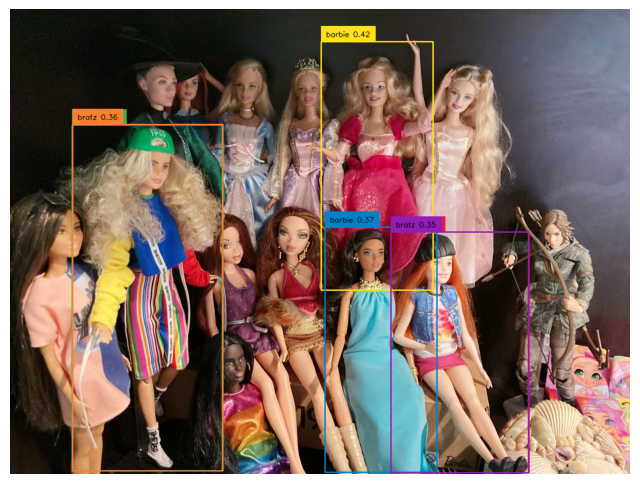

In [49]:
IMAGE_NAME = annot_df['file_name'][14]
IMAGE_PATH = os.path.join(HOME, 'data', IMAGE_NAME)

TEXT_PROMPT = "doll"
TEXT_PROMPT = "; ".join(list(cat_id2name.values()))
BOX_TRESHOLD = 0.35
TEXT_TRESHOLD = 0.25

image_source, image = load_image(IMAGE_PATH)

# ‘cxcywh’ : boxes are represented via centre, width and height, cx, cy being center of box, w, h being width and height.
predicted_boxes, logits, phrases = predict(
    model=model,
    image=image,
    caption=TEXT_PROMPT,
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD
)

annotated_frame = annotate(image_source=image_source, boxes=predicted_boxes,
                           logits=logits, phrases=phrases)

%matplotlib inline
sv.plot_image(annotated_frame, (8, 8))

In [50]:
logits

tensor([0.4683, 0.4470, 0.4156, 0.3680, 0.3646, 0.3506])

In [51]:
phrases

['barbie', 'barbie', 'barbie', 'barbie', 'bratz', 'bratz']

### NMS

In [16]:
def xyxy_iou(xyxy1, xyxy2):
    x1, y1, a1, b1 = xyxy1
    x2, y2, a2, b2 = xyxy2

    # find the area for the box1 (x1,y1) (a1,b1)
    area1 = (a1-x1)*(b1-y1);

    # find the area for the box2 (x2,y2) (a2,b2)
    area2 = (a2-x2)*(b2-y2);

    # Now we need to find the intersection box
    # to do that, find the largest (x, y) coordinates
    # for the start of the intersection bounding box and
    # the smallest (x, y) coordinates for the
    # end of the intersection bounding box
    xx = max(x1, x2)
    yy = max(y1, y2)
    aa = min(a1, a2)
    bb = min(b1, b2)

    # So the intersection BBox has the coordinates (xx,yy) (aa,bb)
    # compute the width and height of the intersection bounding box
    w = max(0, aa - xx)
    h = max(0, bb - yy)

    # find the intersection area
    intersection_area = w*h

    # find the union area of both the boxes
    union_area = area1 + area2 - intersection_area

    # compute the ratio of overlap between the computed
    # bounding box and the bounding box in the area list
    IoU = intersection_area / union_area

    return IoU

In [24]:
# mimics "annotate" function

def convert_pred_boxes_to_xyxy(predicted_boxes, image_source):
    from torchvision.ops import box_convert
    h, w, _ = image_source.shape
    predicted_boxes = predicted_boxes * torch.Tensor([w, h, w, h])
    pred_xyxy = box_convert(boxes=predicted_boxes, in_fmt="cxcywh", out_fmt="xyxy").to(torch.int32)#.numpy()
    # detections = sv.Detections(xyxy=pred_xyxy)
    return pred_xyxy

predicted_boxes_xyxy_torch = convert_pred_boxes_to_xyxy(predicted_boxes=predicted_boxes, image_source=image_source)
predicted_boxes_xyxy_torch

tensor([[ 110,   20,  815, 1273],
        [ 228,   20,  815, 1246]], dtype=torch.int32)

In [18]:
def nms_pytorch(P : torch.tensor, thresh_iou : float):
    """
    Apply non-maximum suppression to avoid detecting too many
    overlapping bounding boxes for a given object.
    Args:
        boxes: (tensor) The location preds for the image
            along with the class predscores, Shape: [num_boxes,5].
        thresh_iou: (float) The overlap thresh for suppressing unnecessary boxes.
    Returns:
        A list of filtered boxes, Shape: [ , 5]
    """

    # we extract coordinates for every
    # prediction box present in P
    x1 = P[:, 0]
    y1 = P[:, 1]
    x2 = P[:, 2]
    y2 = P[:, 3]

    # we extract the confidence scores as well
    scores = P[:, 4]

    # calculate area of every block in P
    areas = (x2 - x1) * (y2 - y1)

    # sort the prediction boxes in P
    # according to their confidence scores
    order = scores.argsort()

    # initialise an empty list for
    # filtered prediction boxes
    keep = []


    while len(order) > 0:

        # extract the index of the
        # prediction with highest score
        # we call this prediction S
        idx = order[-1]

        # push S in filtered predictions list
        keep.append(P[idx])

        # remove S from P
        order = order[:-1]

        # sanity check
        if len(order) == 0:
            break

        # select coordinates of BBoxes according to
        # the indices in order
        xx1 = torch.index_select(x1,dim = 0, index = order)
        xx2 = torch.index_select(x2,dim = 0, index = order)
        yy1 = torch.index_select(y1,dim = 0, index = order)
        yy2 = torch.index_select(y2,dim = 0, index = order)

        # find the coordinates of the intersection boxes
        xx1 = torch.max(xx1, x1[idx])
        yy1 = torch.max(yy1, y1[idx])
        xx2 = torch.min(xx2, x2[idx])
        yy2 = torch.min(yy2, y2[idx])

        # find height and width of the intersection boxes
        w = xx2 - xx1
        h = yy2 - yy1

        # take max with 0.0 to avoid negative w and h
        # due to non-overlapping boxes
        w = torch.clamp(w, min=0.0)
        h = torch.clamp(h, min=0.0)

        # find the intersection area
        inter = w*h

        # find the areas of BBoxes according the indices in order
        rem_areas = torch.index_select(areas, dim = 0, index = order)

        # find the union of every prediction T in P
        # with the prediction S
        # Note that areas[idx] represents area of S
        union = (rem_areas - inter) + areas[idx]

        # find the IoU of every prediction in P with S
        IoU = inter / union

        # keep the boxes with IoU less than thresh_iou
        mask = IoU < thresh_iou
        order = order[mask]

    return keep

In [26]:
torch.concat([predicted_boxes_xyxy_torch, logits.reshape(-1,1)], axis=1)

tensor([[1.1000e+02, 2.0000e+01, 8.1500e+02, 1.2730e+03, 4.1873e-01],
        [2.2800e+02, 2.0000e+01, 8.1500e+02, 1.2460e+03, 4.0765e-01]])

In [25]:
nms_pytorch(P=torch.concat([predicted_boxes_xyxy_torch, logits.reshape(-1,1)], axis=1), thresh_iou=0.5)

[tensor([1.1000e+02, 2.0000e+01, 8.1500e+02, 1.2730e+03, 4.1873e-01])]

## Evaluation example

In [21]:
image_source.shape

(1280, 960, 3)

In [22]:
# box_convert(boxes=annot_df[annot_df['file_name'] == IMAGE_NAME]['bbox'].values[0], in_fmt="xywh", out_fmt="xyxy")

predicted_box [ 110   20  815 1273]
predicted_box [ 228   20  815 1246]


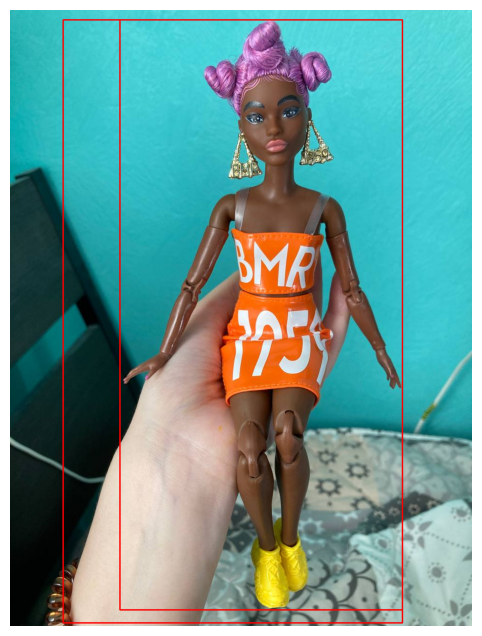

In [27]:
def plot_bb(bb_xyxy_list, img, color=(0, 0, 0), size=(8, 8), plot=True):
    img = deepcopy(img)
    for predicted_box in bb_xyxy_list:
        print('predicted_box', predicted_box)
        img = cv2.rectangle(img=img,
                            pt1=predicted_box[:2],
                            pt2=predicted_box[2:],
                            color=color,
                            thickness=2
                            )
    if plot:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        sv.plot_image(img, size)
    return img

plot_bb(bb_xyxy_list=predicted_boxes_xyxy_torch.numpy(), img=image_source, color=(255, 0, 0));

predicted_box (239, 22, 811, 1242)


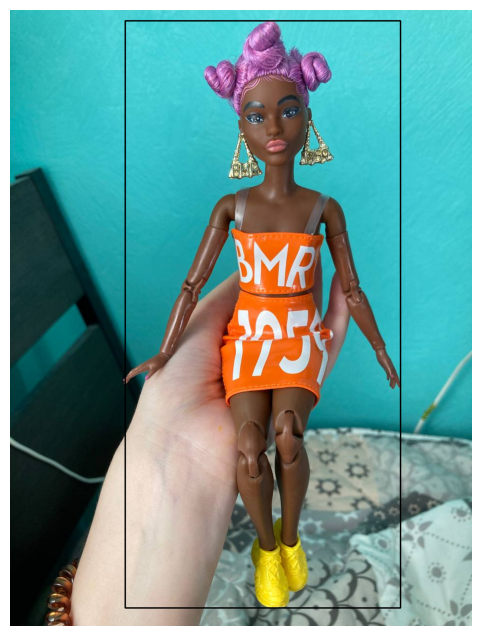

In [28]:
gt_bbox_list = [annot_df[annot_df['file_name'] == IMAGE_NAME].apply(lambda x: x['pt1'] + x['pt2'], axis=1).values[0]]
plot_bb(bb_xyxy_list=gt_bbox_list, img=image_source, color=(0, 0, 0));

In [29]:
def intersection_over_union(gt_box, pred_box):
    """
    Calculate the Intersection over Union (IoU) metric between two bounding boxes.

    The Intersection over Union (IoU) is a common evaluation metric used in object detection tasks
    to measure the overlap between the ground truth box and the predicted box.

    Parameters:
        gt_box (list or tuple): A list or tuple representing the ground truth bounding box.
            It should contain four elements: [x, y, width, height], where x and y are the
            coordinates of the top-left corner of the bounding box, and width and height are
            the dimensions of the bounding box.
        pred_box (list or tuple): A list or tuple representing the predicted bounding box.
            It should also contain four elements: [x, y, width, height], where x and y are the
            coordinates of the top-left corner of the bounding box, and width and height are
            the dimensions of the bounding box.

    Returns:
        iou (float): The Intersection over Union (IoU) value, representing the overlap between
            the ground truth and predicted bounding boxes. The IoU is defined as the intersection
            area divided by the union area of the two bounding boxes.
        intersection (float): The area of the intersection between the ground truth and predicted
            bounding boxes.
        union (float): The area of the union between the ground truth and predicted bounding boxes.

    Methodology:
        1. Calculate the coordinates of the top-left and bottom-right corners of the intersection
           box by finding the maximum of the x and y coordinates of the input bounding boxes for
           the top-left corner and the minimum of the sum of x and width and y and height for the
           bottom-right corner. This ensures that the intersection box is properly defined and has
           non-negative width and height.
        2. Calculate the width and height of the intersection box by taking the difference between
           the x coordinates and y coordinates of the top-left and bottom-right corners.
        3. Compute the area of intersection by multiplying the width and height of the intersection
           box.
        4. Calculate the area of the union by adding the areas of the ground truth and predicted
           bounding boxes and subtracting the area of intersection to avoid double-counting.
        5. Finally, obtain the Intersection over Union (IoU) value by dividing the area of
           intersection by the area of the union.

    Example Usage:
        gt_box = [10, 10, 50, 30]    # Ground truth bounding box: top-left (10, 10), width 50, height 30
        pred_box = [20, 15, 40, 35]  # Predicted bounding box: top-left (20, 15), width 40, height 35
        iou, intersection, union = intersection_over_union(gt_box, pred_box)
        print("IoU:", iou)
        print("Intersection:", intersection)
        print("Union:", union)

    """
    inter_box_top_left = [max(gt_box[0], pred_box[0]),
                          max(gt_box[1], pred_box[1])]
    inter_box_bottom_right = [min(gt_box[0]+gt_box[2], pred_box[0]+pred_box[2]),
                              min(gt_box[1]+gt_box[3], pred_box[1]+pred_box[3])]

    inter_box_w = inter_box_bottom_right[0] - inter_box_top_left[0]
    inter_box_h = inter_box_bottom_right[1] - inter_box_top_left[1]

    intersection = inter_box_w * inter_box_h
    union = gt_box[2] * gt_box[3] + pred_box[2] * pred_box[3] - intersection

    iou = intersection / union

    return iou, intersection, union

In [33]:
for predicted_box in predicted_boxes_xyxy_torch:
    res = intersection_over_union(
        gt_box=gt_bbox_list[0],
        pred_box=predicted_box)
    print(res)

(tensor(0.7143), tensor(852012, dtype=torch.int32), tensor(1192745, dtype=torch.int32))
(tensor(0.9750), tensor(998568, dtype=torch.int32), tensor(1024184, dtype=torch.int32))


In [34]:
intersection_over_union(
        gt_box=gt_bbox_list[0],
        pred_box=gt_bbox_list[0])

(1.0, 1007262, 1007262)

In [35]:
intersection_over_union(
        gt_box=annot_df[annot_df['file_name'] == IMAGE_NAME]['bbox'].values[0],
        pred_box=annot_df[annot_df['file_name'] == IMAGE_NAME]['bbox'].values[0])

(1.0, 697840.0, 697840.0)

In [36]:
intersection_over_union(
        gt_box=predicted_box,
        pred_box=predicted_box)

(tensor(1.),
 tensor(1015490, dtype=torch.int32),
 tensor(1015490, dtype=torch.int32))

## Eval all

In [44]:
annot_df.groupby('file_name')['id'].size()

file_name
2023-04-19 23.11.11.jpg     1
2023-04-19 23.11.27.jpg     1
2023-04-19 23.11.31.jpg     1
2023-04-19 23.11.33.jpg     1
2023-04-19 23.11.37.jpg     1
2023-04-19 23.11.38.jpg     1
2023-04-19 23.11.40.jpg     1
2023-04-19 23.11.41.jpg     1
2023-04-19 23.11.43.jpg    13
2023-04-19 23.11.46.jpg     1
2023-04-19 23.11.47.jpg     1
2023-04-19 23.11.51.jpg     1
2023-04-19 23.11.52.jpg     1
2023-04-19 23.11.54.jpg     1
2023-04-19 23.16.20.jpg     8
2023-04-19 23.16.34.jpg     5
2023-04-19 23.16.38.jpg     1
2023-04-19 23.16.40.jpg     1
2023-04-19 23.16.42.jpg     1
2023-04-19 23.16.44.jpg     5
2023-04-19 23.16.55.jpg     1
2023-04-19 23.16.59.jpg     1
Name: id, dtype: int64

2023-04-19 23.11.33.jpg


/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:881: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


predicted_box [ 326   47  770 1182]
predicted_box (330, 50, 767, 1181)


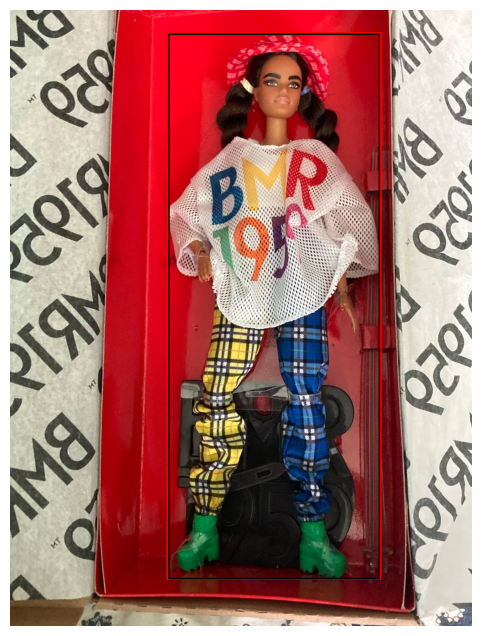

predicted_box [ 326   47  770 1182]
predicted_box (330, 50, 767, 1181)


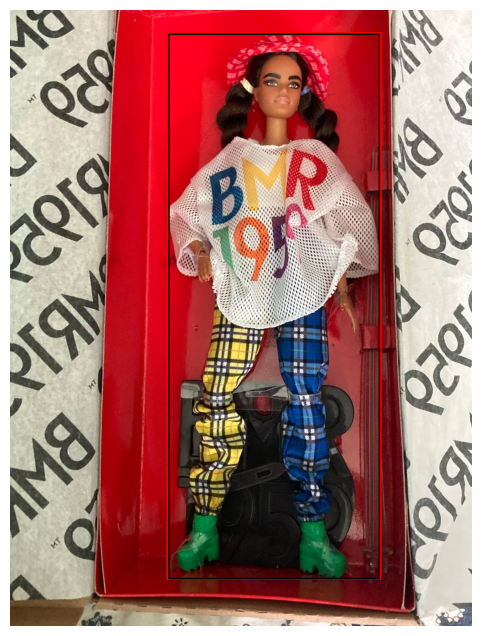

(0.9893312504861134, 903114, 912853)
2023-04-19 23.11.37.jpg


/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:881: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


predicted_box [ 110   20  815 1273]
predicted_box [ 228   20  815 1246]
predicted_box (239, 22, 811, 1242)


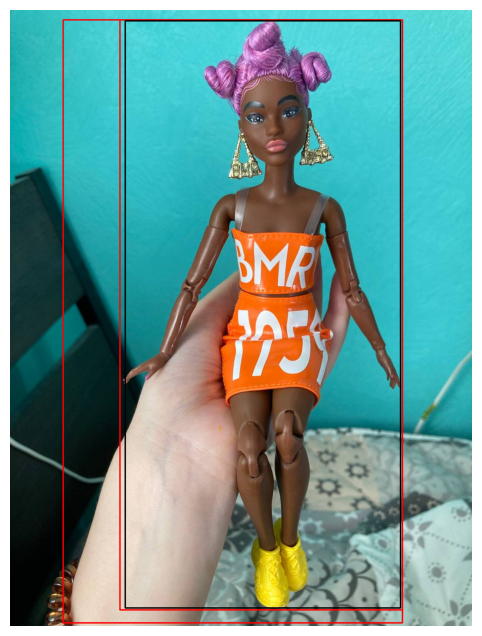

predicted_box [ 110   20  815 1273]
predicted_box (239, 22, 811, 1242)


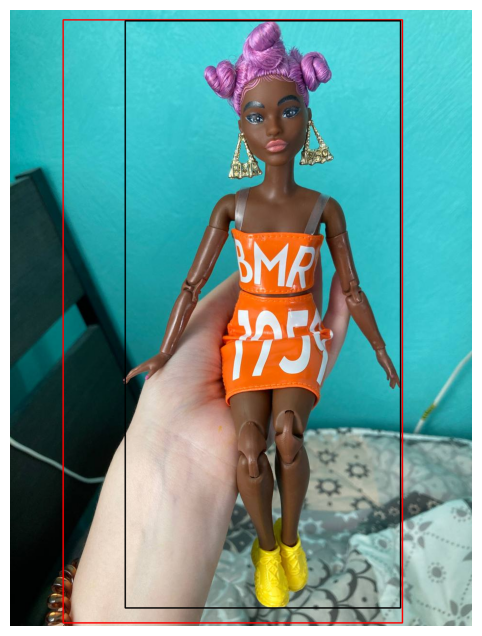

(0.7143287123400224, 852012, 1192745)


In [41]:
TEXT_PROMPT = "doll"
BOX_TRESHOLD = 0.35
TEXT_TRESHOLD = 0.25

for fname in annot_df['file_name'][3: 5]:
    print(fname)
    IMAGE_PATH = os.path.join(HOME, 'data', fname)

    image_source, image = load_image(IMAGE_PATH)

    # ‘cxcywh’ : boxes are represented via centre, width and height, cx, cy being center of box, w, h being width and height.
    predicted_boxes, logits, phrases = predict(
        model=model,
        image=image,
        caption=TEXT_PROMPT,
        box_threshold=BOX_TRESHOLD,
        text_threshold=TEXT_TRESHOLD
    )

    predicted_boxes_xyxy_torch = convert_pred_boxes_to_xyxy(predicted_boxes=predicted_boxes, image_source=image_source)
    img = plot_bb(bb_xyxy_list=predicted_boxes_xyxy_torch.numpy(), img=image_source, color=(255, 0, 0), plot=False)
    gt_bbox_list = [annot_df[annot_df['file_name'] == fname].apply(lambda x: x['pt1'] + x['pt2'], axis=1).values[0]]
    plot_bb(bb_xyxy_list=gt_bbox_list, img=img, color=(0, 0, 0));

    predicted_boxes_xyxy_torch = torch.stack(nms_pytorch(P=torch.concat([predicted_boxes_xyxy_torch, logits.reshape(-1,1)], axis=1), thresh_iou=0.5)).to(torch.int32)[:, :4]
    img = plot_bb(bb_xyxy_list=predicted_boxes_xyxy_torch.numpy(), img=image_source, color=(255, 0, 0), plot=False)
    gt_bbox_list = [annot_df[annot_df['file_name'] == fname].apply(lambda x: x['pt1'] + x['pt2'], axis=1).values[0]]
    plot_bb(bb_xyxy_list=gt_bbox_list, img=img, color=(0, 0, 0));

    for predicted_box in predicted_boxes_xyxy_torch.numpy():
        res = intersection_over_union(
            gt_box=gt_bbox_list[0],
            pred_box=predicted_box)
        print(res)

## 🏆 Congratulations

### Learning Resources

Roboflow has produced many resources that you may find interesting as you advance your knowledge of computer vision:

- [Roboflow Notebooks](https://github.com/roboflow/notebooks): A repository of over 20 notebooks that walk through how to train custom models with a range of model types, from YOLOv7 to SegFormer.
- [Roboflow YouTube](https://www.youtube.com/c/Roboflow): Our library of videos featuring deep dives into the latest in computer vision, detailed tutorials that accompany our notebooks, and more.
- [Roboflow Discuss](https://discuss.roboflow.com/): Have a question about how to do something on Roboflow? Ask your question on our discussion forum.
- [Roboflow Models](https://roboflow.com): Learn about state-of-the-art models and their performance. Find links and tutorials to guide your learning.

### Convert data formats

Roboflow provides free utilities to convert data between dozens of popular computer vision formats. Check out [Roboflow Formats](https://roboflow.com/formats) to find tutorials on how to convert data between formats in a few clicks.

### Connect computer vision to your project logic

[Roboflow Templates](https://roboflow.com/templates) is a public gallery of code snippets that you can use to connect computer vision to your project logic. Code snippets range from sending emails after inference to measuring object distance between detections.